In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
import zipfile
import os

In [76]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/STAT5243finalproject/archive.zip'

extract_to_path = '/content/drive/MyDrive/Colab Notebooks/STAT5243finalproject/archive'

os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [2]:
import pandas as pd
file_path = '/content/drive/MyDrive/Colab Notebooks/STAT5243finalproject/archive/chineseMNIST.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [4]:
df.shape

(15000, 4098)

In [5]:
pixel_data = df.drop(["label", "character"], axis=1)
pixel_data.shape

(15000, 4096)

In [6]:
label_counts = df['label'].value_counts()
print(label_counts)

label
9            1000
10           1000
100          1000
1000         1000
10000        1000
100000000    1000
0            1000
1            1000
2            1000
3            1000
4            1000
5            1000
6            1000
7            1000
8            1000
Name: count, dtype: int64


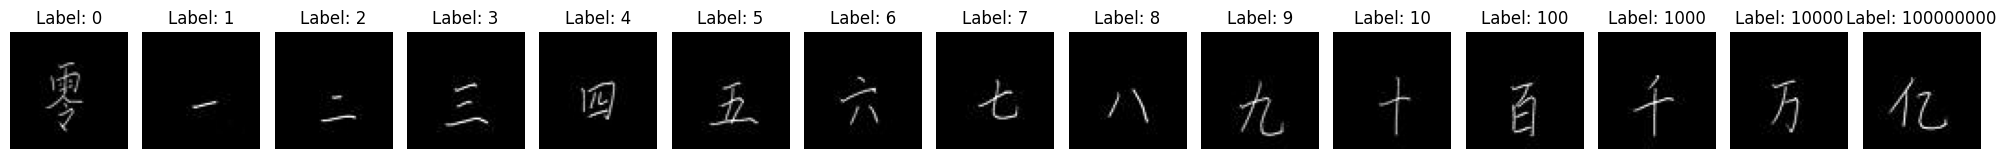

In [7]:
import matplotlib.pyplot as plt
import numpy as np

sorted_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000, 10000, 100000000]

selected_images = df[df['label'].isin(sorted_labels)].drop_duplicates('label')
selected_images = selected_images.set_index('label').loc[sorted_labels]

selected_images_numeric = selected_images.drop("character", axis=1).apply(pd.to_numeric)

fig, axes = plt.subplots(1, len(sorted_labels), figsize=(20, 5))
axes = axes.flatten()

# Plot the images
for i, (label, row) in enumerate(selected_images_numeric.iterrows()):
    image = row.values.astype(float).reshape(64, 64)

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [8]:
# Normalize pixel values to [0, 1]
pixel_data = pixel_data / 255.0

In [9]:
reshaped_images = pixel_data.values.reshape(-1, 64, 64, 1)

In [10]:
reshaped_images.shape

(15000, 64, 64, 1)

In [11]:
df_label = df["label"]
df_label.replace(100, 11, inplace=True)
df_label.replace(1000, 12, inplace=True)
df_label.replace(10000, 13, inplace=True)
df_label.replace(100000000, 14, inplace=True)

In [12]:
from tensorflow.keras.utils import to_categorical
df_label_onehot = to_categorical(df_label, num_classes = 15)

In [13]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(reshaped_images, df_label_onehot,
                                                    test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (10500, 64, 64, 1) (10500, 15)
Validation set: (2250, 64, 64, 1) (2250, 15)
Test set: (2250, 64, 64, 1) (2250, 15)


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

train_gen = datagen.flow(X_train, y_train, batch_size=64)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 1)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(15, activation="softmax"),
])


# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"]
)
# Fit the model
history = model.fit(train_gen,
                    epochs = 50,
                    validation_data=(X_test, y_test),
                    batch_size=64)
#Above code is copied from https://www.kaggle.com/code/carlosbrown88/beginners-chinese-mnist-digit-recognizer with minor modification

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.2005 - loss: 2.4682 - val_accuracy: 0.5671 - val_loss: 1.4529
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5325 - loss: 1.4678 - val_accuracy: 0.7249 - val_loss: 0.8924
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.6571 - loss: 1.0459 - val_accuracy: 0.7893 - val_loss: 0.6736
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.7091 - loss: 0.8478 - val_accuracy: 0.8342 - val_loss: 0.5512
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7499 - loss: 0.7293 - val_accuracy: 0.8476 - val_loss: 0.4816
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7813 - loss: 0.6706 - val_accuracy: 0.8369 - val_loss: 0.4745
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7920 - loss: 0.6060 - val_accuracy: 0.8484 - val_loss: 0.4267
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8068 - loss: 0.5756 - 

In [21]:
eval = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy =", "{:.5f}%".format(eval[1]*100))
print("Loss     =" ,"{:.5f}".format(eval[0]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9384 - loss: 0.1528
Accuracy = 94.35555%
Loss     = 0.14857


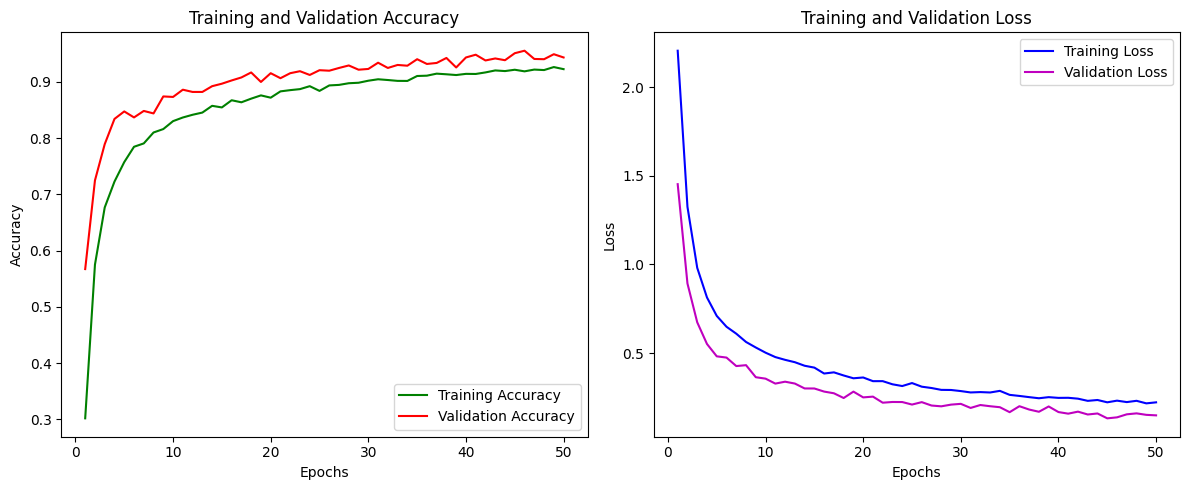

In [32]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'm', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
y_pred = model.predict(X_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [39]:
class_names = np.unique(df_label[:]).astype(str)

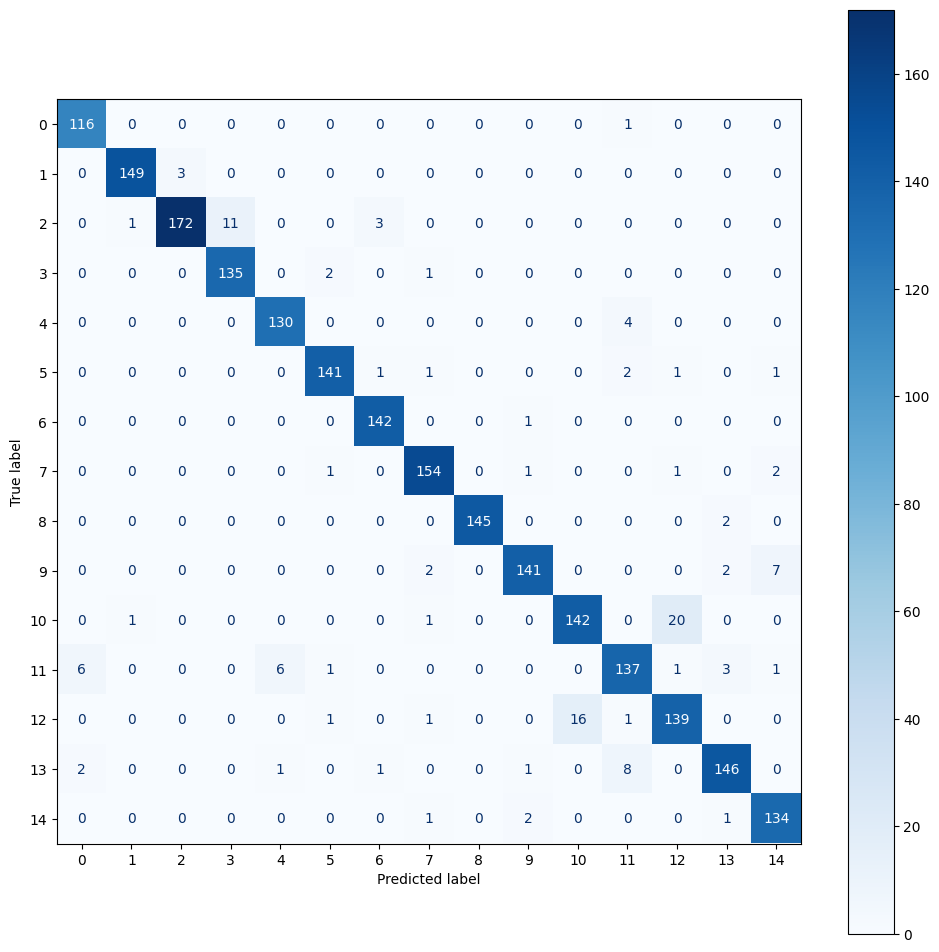

In [40]:
from  sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def confusion_matrix_display(y_true, y_pred, classes=None, figsize=(10, 10), cmap="Blues"):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        cmap: Colormap to use for heatmap (default="Blues").

    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.
    """
    y_pred_index = y_pred.argmax(axis=1) # get the index of the max probability
    # Create the confusion matrix
    cm = confusion_matrix(tf.round(y_pred_index), y_true)
    # Are there a list of classes?
    if classes is not None:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    cmd.plot(ax=ax, cmap=cmap)
confusion_matrix_display(y_true=np.argmax(y_test, axis=1),
                         y_pred=y_pred,
                         classes=class_names,
                         figsize=(12, 12),
                         cmap="Blues")
    #Above code is copied from https://www.kaggle.com/code/carlosbrown88/beginners-chinese-mnist-digit-recognizer with minor modification